In [2]:
# Name: Sitong Mu; Github username: edsml-sm1122
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 12.0 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import datetime, time
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses
from pycm import *
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from torchsummary import summary

In [4]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# to import utilitis
import sys
sys.path.insert(0,'/content/drive/MyDrive/IRP/codefinal')
from utilities import convert_deg_to_sin_cos,normalize,generate_random_numbers,lstmDataset,LSTMCell,LSTM,LSTM_GEN,train_lstm_gen,val_lstm_gen,count_trainable_parameters

In [7]:
#read data, feature engineering, normalization, reshaping

#track, time(1800s), space(0.01degree,~1km), ['MWD','PWP','SWH','TWD','WiD','WiS']
m25 = np.load('/content/drive/MyDrive/IRP/data/structured/DepthContour25m.npy')
m25 = np.delete(m25, (45,83,77),axis=0)
print(f"Feature before reshaping: {np.shape(m25)}")

m0 = np.load('/content/drive/MyDrive/IRP/data/structured/Coastline0p01.npy')
m0 = np.delete(m0, (45,83,77),axis=0)
# for each trach, each parameter, the first timestep data is just the index of the stations
m25 = m25[:,1:,:,:]
m0 = m0[:,1:,:,:]

#tar is SWH at coastline
tar = m0[:,:,:,2]
tar[np.isnan(tar)] = 0
print(f"Target before reshaping: {np.shape(tar)}")

#reshape target and features (track and time dim)
tar_rs = np.reshape(tar, (np.shape(tar)[0]*np.shape(tar)[1],np.shape(tar)[2]))
print(f"Target after reshaping (also Target final): {np.shape(tar_rs)}")

feature25m = np.reshape(m25, (np.shape(m25)[0]*np.shape(m25)[1],np.shape(m25)[2],np.shape(m25)[3]))
print(f"Feature after reshaping: {feature25m.shape}")

# convert 2 degree dimentions to sin and cos, now the third dimention is ['sin(MWD)',cos(MWD),'PWP','SWH','TWD',sin('WiD'),cos(WiD),'WiS']
feature25m = convert_deg_to_sin_cos(feature25m)
print('Feature after FE:', feature25m.shape)

#reshape sapce and parameters to 1d to deef into model
feature25m = feature25m.reshape(feature25m.shape[0],feature25m.shape[1]*feature25m.shape[2])
mean25m,std25m,feature25m = normalize(feature25m)
print('Feature final: ', feature25m.shape)

Feature before reshaping: (185, 98, 155, 6)
Target before reshaping: (185, 97, 145)
Target after reshaping (also Target final): (17945, 145)
Feature after reshaping: (17945, 155, 6)
Feature after FE: (17945, 155, 8)
Feature final:  (17945, 1240)


In [8]:
# train_test split such that only the first 80% of tracks used as train
intervel = tar.shape[1]
# use the 25m as train set
split = int(((tar.shape[0]*0.8)//1) * intervel)

assert(feature25m.shape[0]==tar_rs.shape[0])
X_train,y_train = feature25m[:split,:], tar_rs[:split,:]
X_test,y_test = feature25m[split:,:], tar_rs[split:,:]

In [ ]:
print(X_train.shape,y_train.shape)

(14356, 1240) (14356, 145)


In [9]:
#set hyperparamters
input_size = 1240
output_size = 145
n_hidden = 64
n_layers = 2
batch_size = 256
sequence_length = 9

lr = 1e-3

n_epochs = 500


In [10]:
# dataset and dataloader
traindata = lstmDataset(X_train,y_train,sequence_length=sequence_length)
valdata = lstmDataset(X_test,y_test,sequence_length=sequence_length)

train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=False)# set the shuffle to False as order matter for RNN
validation_loader = DataLoader(valdata, batch_size=batch_size, shuffle=False)

In [11]:
#instantiation
lstm_gen = LSTM_GEN(input_size, output_size, n_hidden, n_layers,device=device).to(device)
print(f'The model has {count_trainable_parameters(lstm_gen):,} trainable parameters')


The model has 376,017 trainable parameters


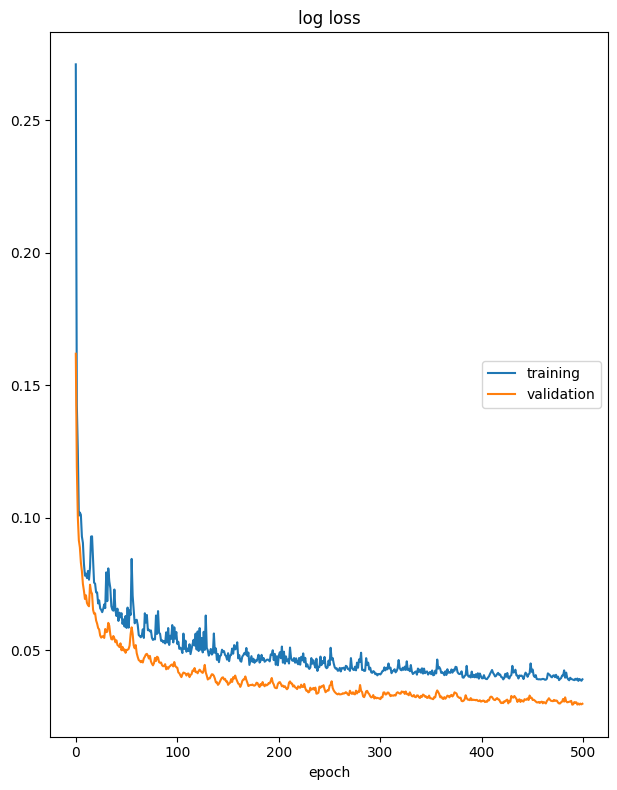

100%|██████████| 500/500 [21:55<00:00,  2.63s/it]

log loss
	training         	 (min:    0.039, max:    0.271, cur:    0.039)
	validation       	 (min:    0.030, max:    0.162, cur:    0.030)


In [ ]:
#train model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_gen.parameters(), lr=lr)

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in tqdm(range(n_epochs)):
    logs = {}
    # print(criterion)
    train_loss = torch.sqrt(train_lstm_gen(lstm_gen, optimizer, criterion, train_loader,device=device))
    val_loss = torch.sqrt(val_lstm_gen(lstm_gen, criterion, validation_loader,device=device))
    # print('1')

    print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = val_loss.item()
    liveloss.update(logs)
    liveloss.draw()

    ## save a model every 5 epochs
    # if (epoch > 5) and ( (epoch+1) % 5) == 0:
    #   torch.save(lstm_gen.state_dict(), f'/content/gdrive/MyDrive/BigData/assessment/modelpca_{epoch+1}_3_5')

In [ ]:
# plot image
a,b = next(iter(validation_loader ))
a, b = a.to(device), b.to(device)
res = lstm_gen(a)
criterion(res,b)

tensor(0.0010, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

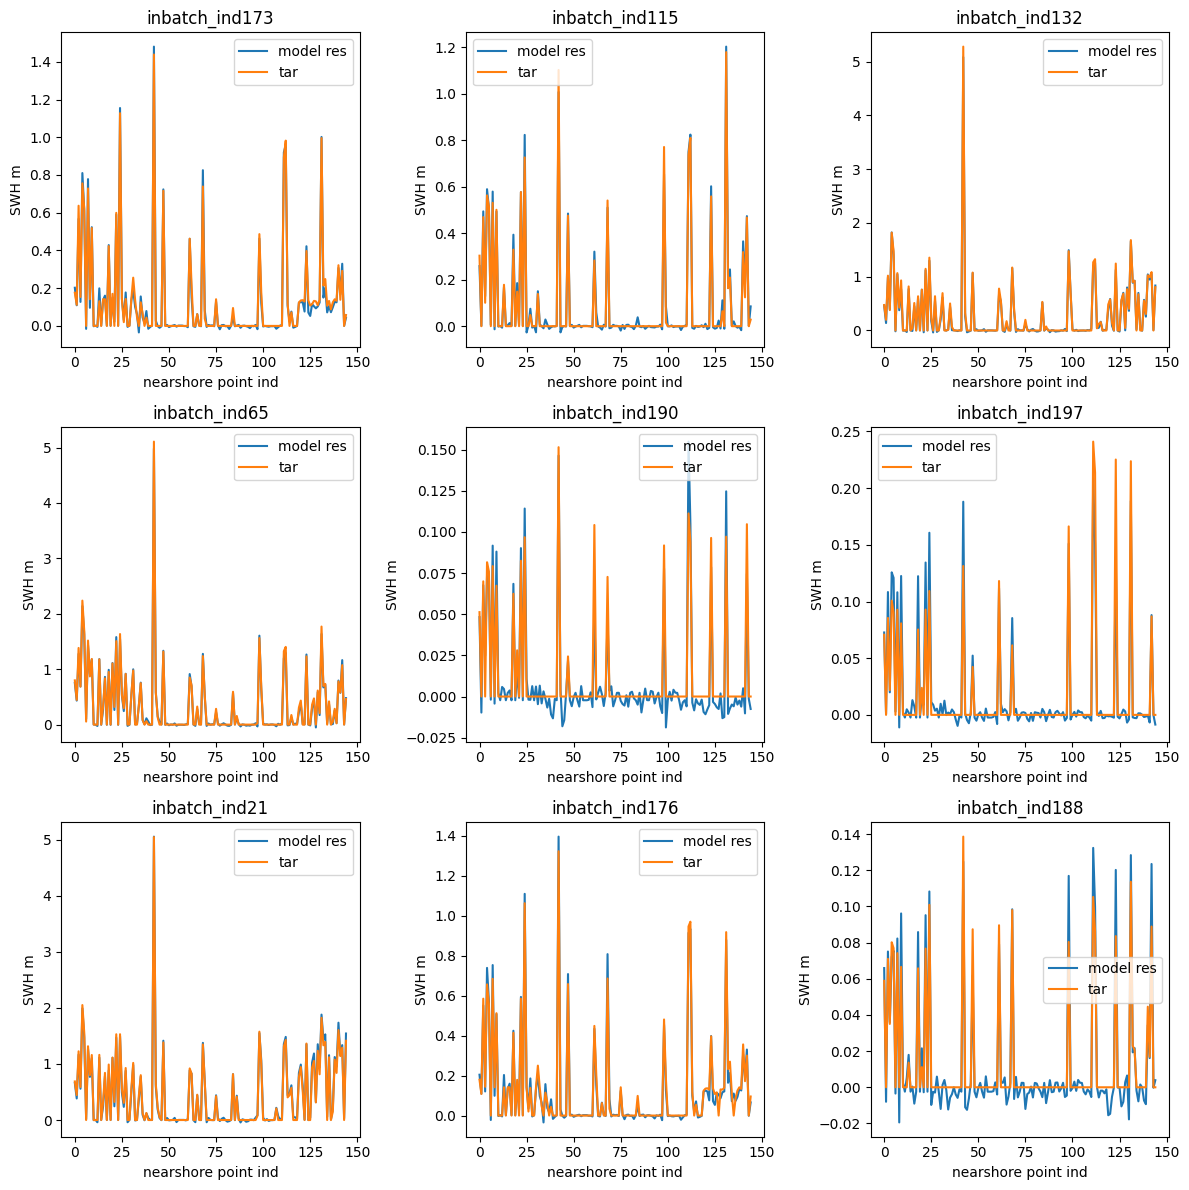

In [ ]:
fig = plt.figure(figsize=(12, 12))
fignum = 9
for ind,i in enumerate(generate_random_numbers(fignum, 0, 255)):
    plt.subplot(3, 3, ind+1)
    plt.plot(res[i,-1,:].cpu().detach().numpy(), label=f'model res') # -1 here, use the last of the sequence as output
    plt.plot(b[i,-1,:].cpu().detach().numpy(), label=f'tar')

    plt.xlabel('nearshore point ind')
    plt.ylabel('SWH m')
    plt.title(f'inbatch_ind{i}')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# torch.save(lstm_gen, '/content/drive/MyDrive/IRP/model/LSTM25m_structured.npy')